In [14]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


In [15]:
'''Load data'''
data_joint_vecs = np.load('input/000009.npy')
#new_joint_vcs = np.load('HumanML3D/new_joint_vecs/000009.npy')
print(data_joint_vecs.shape) # Need to get our data in the form of new_joint_vecs

'''Load csv data'''
# Store the csv file as a numpy array
emilya = np.genfromtxt('input/Nt1KD1_Actor1_worldpos.csv', delimiter=',', skip_header=1)

# Remove the first column (time)
emilya = emilya[:,1:]

# Reshape the array to frames, joints, 3d positions
emilya = emilya.reshape(-1, 28, 3)
print(emilya.shape)

(115, 22, 3)
(283, 28, 3)


In [16]:
'''The joints are too close, so re-scale the distance between them'''
def scale_distances(data, scale_factor=2.0):
    scaled_data = np.copy(data)
    for frame in range(data.shape[0]):
        for i in range(1, data.shape[1]):
            # Calculate the distance between the current joint and the previous joint
            distance = np.linalg.norm(data[frame, i] - data[frame, i-1])
            
            # Scale the distance
            scaled_distance = distance * scale_factor
            
            # Adjust the joint position based on the scaled distance
            direction = (data[frame, i] - data[frame, i-1]) / distance # Get the direction from the previous joint to the current joint
            scaled_data[frame, i] = scaled_data[frame, i-1] + direction * scaled_distance # Update position
    return scaled_data

emilya = scale_distances(emilya, 6.5)


In [17]:
'''Normalise the data'''
def normalise(data):
    min_val = np.min(emilya)
    max_val = np.max(emilya)
    emilya_normalise = (emilya - min_val) / (max_val - min_val)
    emilya_normalise = emilya_normalise * 2 - 1

    return emilya_normalise

emilya = normalise(emilya)

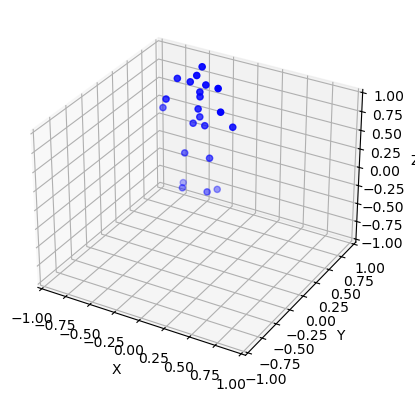

In [18]:
'''Display HumanML3D data'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # Add 3D axis

# Set the axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# Get x,y,z coordinates for each joint
x = data_joint_vecs[0, :, 0]
y = data_joint_vecs[0, :, 1]
z = data_joint_vecs[0, :, 2]

# Plot the datapoints
ax.scatter(x, z, y, c='b', marker='o')

"\njoint_num = 24\n\nx_point = emilya[frame, joint_num, 0]\ny_point = emilya[frame, joint_num, 1]\nz_point = emilya[frame, joint_num, 2]\n\nax.scatter(x_point, y_point, z_point, c='g', marker='x', s=35)\n"

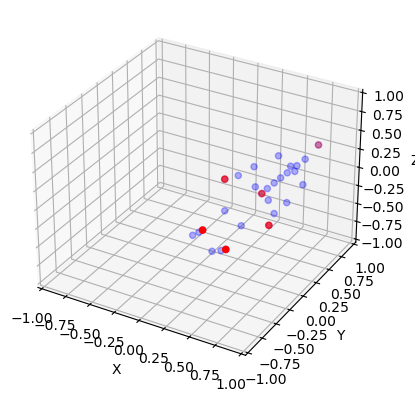

In [19]:
'''Display EMILYA data'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # Add 3D axis   

# Set the axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

frame = len(emilya)-1

# Get x,y,z coordinates for each joint
x = emilya[frame, :, 0]
y = emilya[frame, :, 1]
z = emilya[frame, :, 2]

# Plot the datapoints
ax.scatter(x, y, z, c='b', marker='o', alpha=0.3)

# Locate each individual joint
deleted = [0, 5, 10, 19, 24, 27]

x_new = [emilya[frame, d, 0] for d in deleted] 
y_new = [emilya[frame, d, 1] for d in deleted]
z_new = [emilya[frame, d, 2] for d in deleted]
ax.scatter(x_new, y_new, z_new, c='r', marker='o')


# Code to locate a specific joint
'''
joint_num = 24

x_point = emilya[frame, joint_num, 0]
y_point = emilya[frame, joint_num, 1]
z_point = emilya[frame, joint_num, 2]

ax.scatter(x_point, y_point, z_point, c='g', marker='x', s=35)
'''

In [20]:
''''Remove joints to fit data'''
emilya = np.delete(emilya, deleted, axis=1)
print(data_joint_vecs.shape, emilya.shape)
# Will have some retargeting error hopefully doesnt affect emotion - cannot avoid this 


(115, 22, 3) (283, 22, 3)


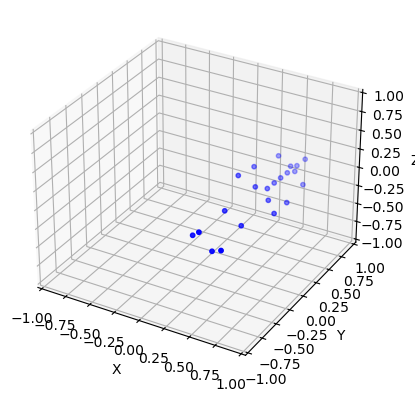

In [21]:
'''Plot modified EMILYA skeleton'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # Add 3D axis   

# Set the axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x = emilya[frame, :, 0] 
y = emilya[frame, :, 1]
z = emilya[frame, :, 2]

ax.scatter(x, y, z, c='b', marker='o', s=10) 


MovieWriter ffmpeg unavailable; using Pillow instead.


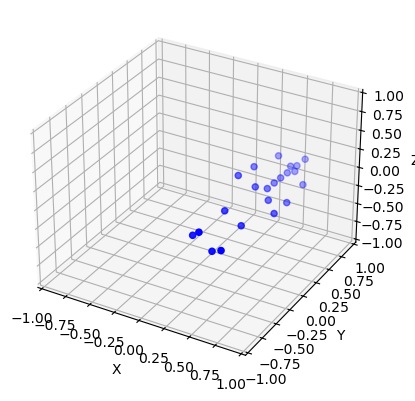

In [22]:
def create_animation(motion, fps=60, frame_skip=2):
    # Create figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set axis limits
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    # Set axis lables
    ax.set_xlabel('X')  
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Initialise scatter plot
    scatter = ax.scatter([], [], [], c='b', marker='o')

    # Used to track the coordinates of each joint in each frame
    def init():
        scatter._offsets3d = ([], [], [])
        return scatter,

    def update(frame):
        x = motion[frame, :, 0]
        y = motion[frame, :, 1]
        z = motion[frame, :, 2]
        scatter._offsets3d = (x, y, z) # The order of axes may need to be changed for better results
        return scatter,

    # Create animation
    ani = FuncAnimation(fig, update, frames=range(0, motion.shape[0], frame_skip), init_func=init, blit=True)

    # Save animation as a gif
    ani.save('output/output.gif', fps=fps)
    plt.show()

create_animation(emilya, fps=60, frame_skip=2)

In [ ]:
'''If the animation good save as a npy file'''
np.save('output/output.npy', emilya)